# Model Agnostic Methods

As models become more and more complex, our ability to understand them with our monkey brains decreases. We can understand how they function, but it becomes impossible to follow the exact mathematical inner-workings. This is what is widely known as a **black-box** model. There is a widely-shared notion that black box models are uninterpretable and we cannot understand how they work.

In my opinion, this is lazy and is spread by fearmongers who have never attempted it. As a whole, models are deterministic. Even if we can't see what is going on inside, we can still observe the input and the output. We can fall back to the naive, childish ways of Deedee "Ooh, what does this button do?". 

This is the essence of model-agnostic methods. We modify the input in a controlled way and observe the change in output in order to reason about the behaviour of the model. 

This notebook will explore the following techniques:

1. Partial Dependence Plot (PDP) - observe the mean prediction as a given feature is set to a given level for the **entire** dataset
2. Permutation Feature Importance - measure the dip in performance as information about a given feature is lost (via permutation)

## Data Loading

In [20]:
from __future__ import print_function
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import fastprogress
import seaborn as sns
sns.set('talk')
sns.set_style('white')

In [146]:
data = pd.read_csv("data/CAR DETAILS FROM CAR DEKHO.csv")
data['brand'] = data['name'].apply(lambda x: x.split(' ')[0])
data['selling_price'] = data['selling_price'] * 0.014
data['selling_price'] = data['selling_price'] / 1000
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,brand
0,Maruti 800 AC,2007,0.84,70000,Petrol,Individual,Manual,First Owner,Maruti
1,Maruti Wagon R LXI Minor,2007,1.89,50000,Petrol,Individual,Manual,First Owner,Maruti
2,Hyundai Verna 1.6 SX,2012,8.40,100000,Diesel,Individual,Manual,First Owner,Hyundai
3,Datsun RediGO T Option,2017,3.50,46000,Petrol,Individual,Manual,First Owner,Datsun
4,Honda Amaze VX i-DTEC,2014,6.30,141000,Diesel,Individual,Manual,Second Owner,Honda


In [147]:
valid_ds = pd.read_csv("data/valid.csv",index_col=0)
valid_ids = valid_ds.index

## Train a Neural Network via fast.ai

The fast.ai library provides us with a modern neural net architecture for tabular data that can handle categorical variables by associating them with learned embeddings.



In [148]:
from fastai.tabular.all import *

In [162]:
CATEGORICAL_FEATURES = ["year", "fuel", "seller_type", "transmission", "owner", "brand"]

dls = TabularDataLoaders.from_df(data, 
                                 cat_names=CATEGORICAL_FEATURES, 
                                 cont_names=["km_driven"],
                                 valid_idx=valid_ids,
                                 y_names="selling_price", 
                                 procs=[Categorify, FillMissing, Normalize])

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=1.3182567499825382e-06)

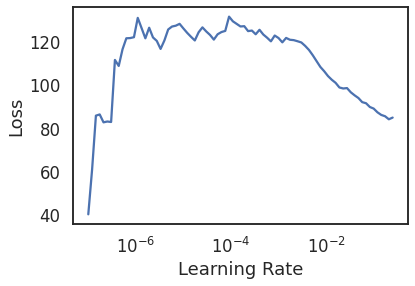

In [163]:
learn = tabular_learner(dls,loss=mse, metrics=rmse)
learn.lr_find()

In [164]:
learn.fit_one_cycle(12, 0.01)

epoch,train_loss,valid_loss,_rmse,time
0,63.488880,28.220562,5.312303,00:00
1,33.898304,9.028476,3.004742,00:00
2,24.585161,11.467145,3.386317,00:00
3,19.954639,9.195740,3.032448,00:00
4,18.126949,9.324531,3.053609,00:00
5,15.403184,8.436892,2.904633,00:00
6,13.920797,7.357744,2.712516,00:00
7,13.280325,8.127924,2.850951,00:00
8,11.357219,7.027699,2.650981,00:00
9,10.853699,6.319430,2.513848,00:00


In [165]:
learn.fit_one_cycle(12, 0.01)

epoch,train_loss,valid_loss,_rmse,time
0,9.828335,6.136335,2.477163,00:00
1,11.116221,10.058124,3.171454,00:00
2,13.342880,9.628558,3.102992,00:00
3,13.606737,9.249454,3.041291,00:00
4,13.640829,7.198144,2.682936,00:00
5,13.094580,6.919735,2.630539,00:00
6,11.066231,6.115360,2.472926,00:00
7,10.766758,6.381833,2.526229,00:00
8,9.528748,6.751826,2.598428,00:00
9,8.626515,5.834229,2.415415,00:00


In [166]:
learn.fit_one_cycle(12, 0.001)

epoch,train_loss,valid_loss,_rmse,time
0,6.435252,5.810737,2.410547,00:00
1,6.575485,5.767293,2.401519,00:00
2,6.887302,5.745071,2.396888,00:00
3,7.052296,5.848242,2.418314,00:00
4,6.868080,5.650592,2.377097,00:00
5,7.039893,5.757898,2.399562,00:00
6,6.522229,5.720667,2.391792,00:00
7,6.483643,5.675679,2.382368,00:00
8,6.048038,5.735871,2.394968,00:00
9,6.078085,5.686973,2.384737,00:00


In [167]:
learn.fit_one_cycle(12, 0.001)

epoch,train_loss,valid_loss,_rmse,time
0,6.057121,5.667470,2.380645,00:00
1,6.123220,5.507756,2.346861,00:00
2,6.161911,5.865140,2.421805,00:00
3,6.063426,5.607372,2.367989,00:00
4,6.238139,5.900138,2.429020,00:00
5,6.060238,5.780100,2.404184,00:00
6,5.767727,5.551015,2.356059,00:00
7,5.683586,5.671179,2.381424,00:00
8,5.381555,5.489024,2.342867,00:00
9,5.503377,5.657499,2.378550,00:00


In [160]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(28, 10)
    (1): Embedding(6, 4)
    (2): Embedding(4, 3)
    (3): Embedding(3, 3)
    (4): Embedding(6, 4)
    (5): Embedding(30, 11)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=36, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

## Partial Dependence Plot

The procedure to obtain a partial dependence plot is as follows: for a given feature, define a set of feature values. For each feature value, copy the input data but replace the original feature value with the surrogate. Afterwards, run inference and record the mean prediction. The PDP is simply a plot of the mean predictions (over the entire dataset) at each feature value.

For example, for continuous variables, we might decide to evaluate the PDP at every (max - min) / 100 feature value.
For categorical variables, it is even easier - simply observe the mean prediction when we substitute the feature values for the entire dataset with each category.

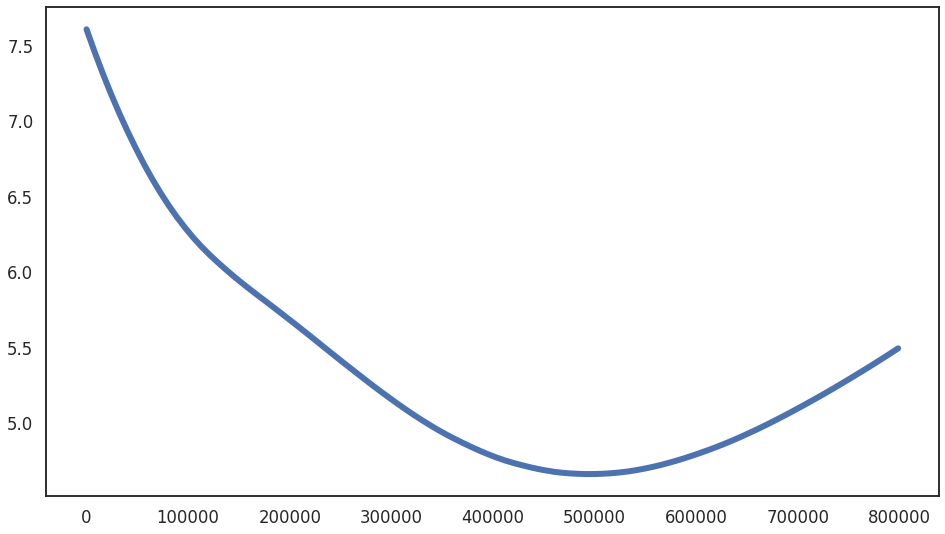

In [168]:
feat = "km_driven"
min_fv = data[feat].min()
max_fv = data[feat].max()
preds_by_fv = {}
for fv in fastprogress.progress_bar(np.arange(min_fv, max_fv, (max_fv - min_fv)/ 100)):
    modified_df = data.copy()
    modified_df[feat] = fv
    modified_dl = learn.dls.test_dl(modified_df)
    with learn.no_bar():
        preds = learn.get_preds(dl=modified_dl)
    preds_by_fv[fv] = preds[0].mean().item()
ax = pd.Series(preds_by_fv).plot(figsize=(16,9),lw=6)

In [184]:
@interact(cat_feat=CATEGORICAL_FEATURES)
def plot_cat_feat_pdp(cat_feat="year"):
    preds_by_fv = {}
    for fv in learn.dls.categorify[cat_feat]:
        if fv == '#na#': continue
        modified_df = data.copy()
        modified_df[cat_feat] = fv
        modified_dl = learn.dls.test_dl(modified_df)
        with learn.no_bar():  preds = learn.get_preds(dl=modified_dl)
        preds_by_fv[fv] = preds[0].mean().item()
    ax = pd.Series(preds_by_fv).sort_values().plot(kind='barh',figsize=(16,9))
    sns.despine(ax=ax)
    ax.set_title(f"Partial Dependence Plot for {feat}")
    ax.set_xlabel("Mean Prediction")
    ax.set_ylabel("Feature Value")

interactive(children=(Dropdown(description='cat_feat', options=('year', 'fuel', 'seller_type', 'transmission',…

## Permutation Feature Importance

Permutation feature importance attemps to quantify the utility of a given feature by breaking the connection between the feature and the target variable.

The process is as follows:

1. Pick a feature
2. Randomly shuffle the feature for the validation dataset
3. Measure the relative drop in prediction quality

The reasoning is that permuting the important features will result in a higher drop because the model relies on them.

In [176]:
error_before = rmse(*predict_with_ds(valid_ds))
error_before

9467.42795061045

In [182]:
def predict_with_ds(ds):
    dl = learn.dls.test_dl(ds)
    with learn.no_bar():
        return learn.get_preds(dl=dl)

def rmse(preds, targets):
    return math.sqrt(((preds - targets)**2).mean().item())


def calculate_permutation_loss(feat):
    permuted = valid_ds.copy()
    permuted[feat] = np.random.permutation(permuted[feat])
    error_after = rmse(*predict_with_ds(permuted))
    return error_after - error_before
    
calculate_permutation_loss("km_driven")

0.40770491293915256

Since randomness is involved in the process, it helps to repeat the process a number of times and take the mean. 

Let's calculate the importance for each feature and analyze the results:

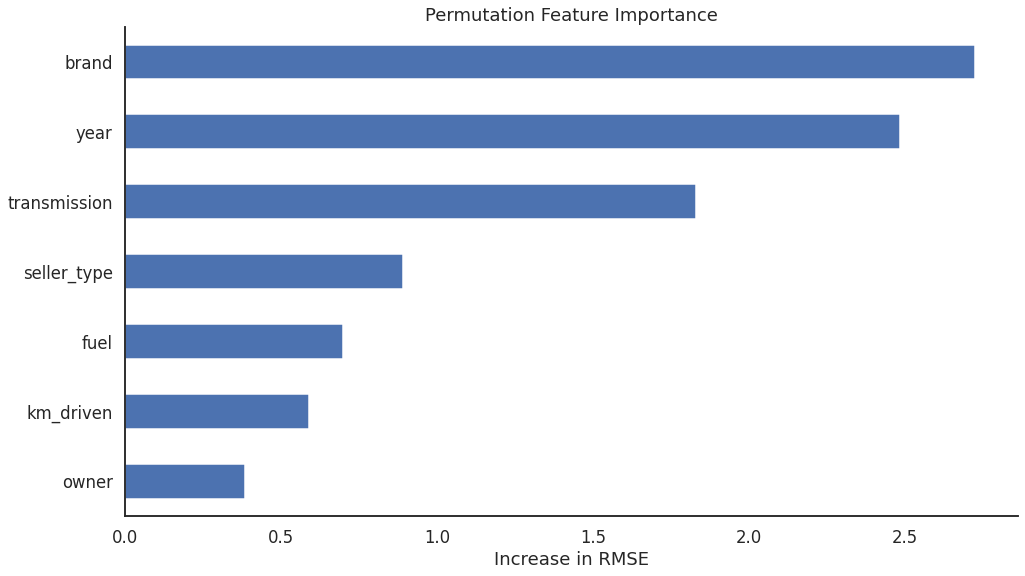

In [183]:
permutation_losses = {}
for feat in ["km_driven"] + CATEGORICAL_FEATURES:
    # repeat the experiment 10 times and take the mean
    feature_losses = np.mean([calculate_permutation_loss(feat) for _ in range(10)])
    permutation_losses[feat] = feature_losses
ax = pd.Series(permutation_losses).sort_values().plot(figsize=(16,9), kind='barh')
sns.despine(ax=ax)
ax.set_title("Permutation Feature Importance")
ax.set_xlabel("Increase in RMSE");